In [1]:
import os
from dotenv import load_dotenv
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch.nn as nn
from IPython.display import display

load_dotenv()

API_TOKEN = os.getenv("API_TOKEN")
headers = {"Authorization": f"Bearer {API_TOKEN}"}


In [2]:
processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/home/marin/.cache/pypoetry/virtualenvs/fashion-YkPqBFHP-py3.12/lib/python3.12/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [3]:
legend_labels = {
    "0": "Background", "1": "Hat", "2": "Hair", "3": "Sunglasses", "4": "Upper-clothes",
    "5": "Skirt", "6": "Pants", "7": "Dress", "8": "Belt", "9": "Left-shoe", "10": "Right-shoe",
    "11": "Face", "12": "Left-leg", "13": "Right-leg", "14": "Left-arm", "15": "Right-arm",
    "16": "Bag", "17": "Scarf"
}

custom_colormap = {
    0: (0, 0, 0), 1: (0, 255, 255), 2: (0, 165, 255), 3: (255, 0, 255), 4: (0, 0, 255),
    5: (255, 255, 0), 6: (0, 255, 0), 7: (255, 0, 0), 8: (128, 0, 128), 9: (0, 255, 255),
    10: (255, 140, 0), 11: (200, 180, 140), 12: (200, 180, 140), 13: (200, 180, 140),
    14: (200, 180, 140), 15: (200, 180, 140), 16: (0, 128, 255), 17: (255, 20, 147)
}

In [4]:
def compute_iou_per_class(pred_mask, gt_mask, num_classes):
    iou_dict = {}
    valid_ious = []

    for cls in range(num_classes):
        pred_cls = pred_mask == cls
        gt_cls = gt_mask == cls

        intersection = np.logical_and(pred_cls, gt_cls).sum()
        union = np.logical_or(pred_cls, gt_cls).sum()

        if union == 0:
            iou = float('nan')  # Classe absente des deux côtés
        else:
            iou = intersection / union
            valid_ious.append(iou)

        iou_dict[cls] = iou

    mean_iou = np.nanmean(valid_ious)

    return  mean_iou

In [ ]:
def displayLabels(predicted_mask):
    labels = np.unique(predicted_mask)
    present_labels = [int(label) for label in labels if label != 0 and str(label) in legend_labels]
    present_classes = [legend_labels[str(label)] for label in present_labels]

    ax = plt.gca()
    y_start = 0.9
    line_height = 0.04

    for i, label_id in enumerate(present_labels):
        y = y_start - i * line_height
        rgb = custom_colormap.get(label_id, (255, 255, 255))
        color = tuple(c/255 for c in rgb)
        ax.add_patch(plt.Rectangle((0.05, y-0.02), 0.03, 0.03, color=color, transform=ax.transAxes))
        plt.text(0.1, y - 0.01, present_classes[i], color='white', fontsize=14, transform=ax.transAxes, verticalalignment='center')
        
def createDisplay(predicted_mask, background, filename=""):
    fig, ax = plt.subplots(figsize=(10, 8))

    plt.imshow(background)
    cmap = mcolors.ListedColormap([tuple(np.array(c)/255) for _, c in sorted(custom_colormap.items())])
    displayLabels(predicted_mask)
    plt.imshow(predicted_mask, cmap=cmap, alpha=0.5)
    plt.axis('off')

    return fig  

def saveFig(fig, filename, placeholder):
    fig.savefig(
        f"./results/{filename}_{placeholder}.png",
        bbox_inches='tight',
        pad_inches=0,
        facecolor=fig.get_facecolor()
    )
    plt.close(fig)



In [6]:
def PredictMask(image):
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits.cpu()
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )
    predicted_mask = upsampled_logits.argmax(dim=1)[0].numpy()
    return predicted_mask

def handleImageAndMask(image, mask, filename, placeholder, compute=False): 
    predicted_mask = PredictMask(image)
    gt_array = np.array(mask) 
    
    if compute == True:
        mean = compute_iou_per_class(predicted_mask, gt_array, num_classes=18)
        print(f"Moyenne IoU (mIoU) : {mean:.3f}")
    
    fig = createDisplay(predicted_mask, mask, filename)
    
    saveFig(fig, filename, placeholder)

def combineImages(original_img, mask_img, predicted_img, filename):
    # Assurez-vous que toutes les images ont la même taille
    size = original_img.size
    mask_img = mask_img.resize(size)
    predicted_img = predicted_img.resize(size)

    # Créer une nouvelle image pour juxtaposer les 3
    total_width = size[0] * 3
    combined_img = Image.new("RGB", (total_width, size[1]))

    # Coller les images
    combined_img.paste(original_img, (0, 0))
    combined_img.paste(mask_img, (size[0], 0))
    combined_img.paste(predicted_img, (size[0] * 2, 0))

    display(combined_img)
    
    # Sauvegarder l'image combinée
    combined_img.save(f"./results/{filename}_combined.png")

In [7]:
def loadImages():
    base_folder = "./dataset/test"
    image_folder = os.path.join(base_folder, "images")
    mask_folder = os.path.join(base_folder, "masks")

    mean_ious = np.array([], dtype=float)

    for filename in os.listdir(image_folder):
        # Load image from path
        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path).convert("RGB")

        # Load Mask from path
        mask_filename = filename.replace("image_", "mask_")
        mask_path = os.path.join(mask_folder, mask_filename)
        mask = Image.open(mask_path).convert("L")
    
        # Générer et sauvegarder les figures overlay
        mean = handleImageAndMask(image, mask, filename, "overlay_mask", True)
        mean_ious = np.append(mean_ious, mean) 

        handleImageAndMask(image, image, filename, "overlay_image", False)

        # Charger les figures comme images
        mask_overlay_path = f"./results/{filename}_overlay_mask.png"
        image_overlay_path = f"./results/{filename}_overlay_image.png"

        mask_overlay_img = Image.open(mask_overlay_path).convert("RGB")
        image_overlay_img = Image.open(image_overlay_path).convert("RGB")

        # Combiner original + mask + prédiction
        combineImages(image, mask_overlay_img, image_overlay_img, filename)

    global_mean = np.mean(mean_ious)
    print(f"Moyenne Globale IoU (mIoU) : {global_mean:.3f}")


Moyenne IoU (mIoU) : 0.810


AttributeError: 'tuple' object has no attribute 'savefig'

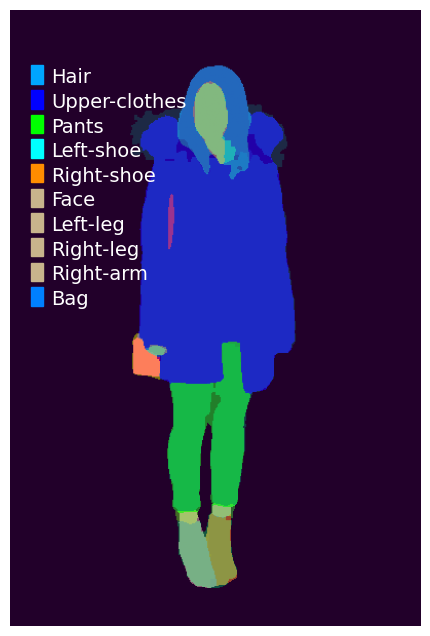

In [8]:
loadImages()
